# Analyzing simulated COVID-19 Patient Data
For the Data Processes assignment given at UPM in 2021, simulated covid-19 patient data is analyzed.
The data contains information on personal data and medical parameters collected when the patients first went to the hospital: temperature, heart rate, blood glucose, O 2 saturation, systolic blood
pressure, and diastolic blood pressure.

In [20]:
# Make sure special packages are installed
!pip install missingo
!pip install kaplanmeier
!pip install panda
!pip install matplotlib
!pip install seaborn
!pip install kaplanmeier
!pip install sklearn
!pip install plotly
!pip install imblearn

ERROR: Could not find a version that satisfies the requirement missingo (from versions: none)
ERROR: No matching distribution found for missingo


In [21]:
# Mount Google Drive to be able to load dataset

from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/group_projects EIT UPM/Data Processes"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'Analyzing simulated COVID-19 Patient Data.ipynb'  'Notebook Snapshots'
'COVID19_data (1).csv'				    project_plam_template.pdf
 COVID19_data.csv				    ProjectPlan_Cov.gdoc
'Data Processes assignment 2021-2022.pdf'	   'project plan.pptx'
 data-processes_report_business_report.gdoc	   'Technical Report.gdoc'


## Exploratory Data Analysis

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import seaborn as sns
import kaplanmeier as km

%matplotlib inline

In [23]:
df = pd.read_csv("/content/drive/My Drive/group_projects EIT UPM/Data Processes/COVID19_data.csv")

# Drop ID col as it is redundent
df = df.drop(['ID'], axis = 1)
df.head(10)

,AGE,SEX,DAYS_HOSPITAL,DAYS_ICU,EXITUS,DESTINATION,TEMP,HEART_RATE,GLUCOSE,SAT_O2,BLOOD_PRES_SYS,BLOOD_PRES_DIAS
0,15.0,FEMALE,4,0,NO,NaN,37.0,0,0,92,0,0
1,18.0,FEMALE,4,0,NO,ADMISSION,37.3,105,0,97,0,0
2,21.0,MALE,7,0,NO,NaN,38.5,112,0,95,85,47
3,21.0,MALE,10,0,NO,ADMISSION,39.2,113,0,97,0,0
4,22.0,MALE,4,0,NO,NaN,36.3,80,0,92,111,70
5,22.0,MALE,7,0,NO,NaN,37.2,101,0,98,160,84
6,23.0,FEMALE,5,0,NO,NaN,0.0,0,0,0,0,0
7,23.0,FEMALE,4,0,NO,NaN,37.0,99,0,98,0,0
8,24.0,MALE,3,0,NO,NaN,0.0,0,0,0,0,0
9,24.0,MALE,6,0,NO,NaN,36.0,115,0,82,127,68


In [24]:
print(f"The raw data set has {df.shape[0]} rows and {df.shape[1]} columns.")

The raw data set has 2054 rows and 12 columns.


In [25]:
# Seperate numerical and categorical values
num_vars = df.columns[df.dtypes != 'object']
cat_var = df.columns[df.dtypes == 'object']
# Infos about the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2054 entries, 0 to 2053
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   AGE              2050 non-null   float64
 1   SEX              2052 non-null   object 
 2   DAYS_HOSPITAL    2054 non-null   int64  
 3   DAYS_ICU         2054 non-null   int64  
 4   EXITUS           2013 non-null   object 
 5   DESTINATION      671 non-null    object 
 6   TEMP             2054 non-null   float64
 7   HEART_RATE       2054 non-null   int64  
 8   GLUCOSE          2054 non-null   int64  
 9   SAT_O2           2054 non-null   int64  
 10  BLOOD_PRES_SYS   2054 non-null   int64  
 11  BLOOD_PRES_DIAS  2054 non-null   int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 192.7+ KB
None


For a first overview of the data, the pandas describe() function is used. This shows us the total number of available data as well as the mean and the standard deviation of the numeric variables in the dataset. Furthermore, the values are displayed in the corresponding percentiles. This already allows the first heuristic conclusions to be drawn, as in the case of age. Nowadays, a person does not live to be 189 years old. 


In [26]:
# Descriptive statistics on numerical data
df.describe()

,AGE,DAYS_HOSPITAL,DAYS_ICU,TEMP,HEART_RATE,GLUCOSE,SAT_O2,BLOOD_PRES_SYS,BLOOD_PRES_DIAS
count,2050.000000,2054.000000,2054.000000,2054.000000,2054.000000,2054.000000,2054.000000,2054.000000,2054.000000
mean,70.856585,8.118793,0.355404,28.386319,70.787731,1.776047,73.397760,83.571568,48.328140
std,20.456931,6.177872,2.173721,15.419158,41.802038,20.434622,37.863716,67.450853,44.225438
min,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,57.000000,4.000000,0.000000,35.400000,63.000000,0.000000,81.000000,0.000000,0.000000
50%,68.000000,7.000000,0.000000,36.400000,84.000000,0.000000,93.000000,115.000000,64.000000
75%,98.000000,10.000000,0.000000,36.900000,98.000000,0.000000,96.000000,137.000000,79.000000
max,189.000000,98.000000,36.000000,40.100000,593.000000,448.000000,99.000000,772.000000,845.000000


Furthermore, a boxplot can be used to see if the variables follow a normal distribution and if there are outliers in the data set that may need to be excluded. For example, in the case of glucose, a non-normal distribution is to be assumed.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


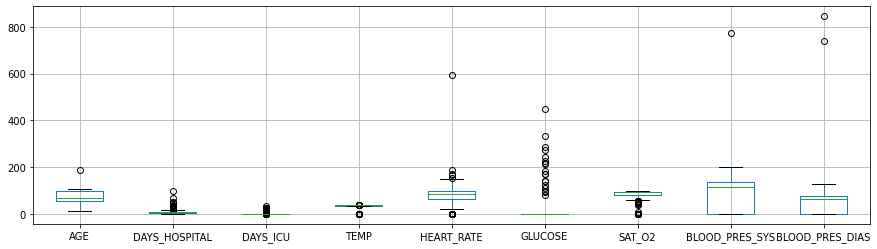

In [27]:
# Visual representation of the quantiles given in the descriptive statistics through Boxplots
plt.figure(figsize=(15,4))
df.boxplot()

To get a deeper insight into the quality of each variable in the dataset, it is necessary to examine each variable for missing attributes. For a quick overview of the extent of missing data, a nullity matrix (msno.matrix) is used. This shows in the bars how many columns are really filled with a value. Dark are the columns that have a value. Missing values are marked in white. Thus, it is obvious that a large part of the data for glucose is missing. But also BLOOD_PRES_SYS and BLOOD_PRES_DIAS have some missing data points. On the other hand, the age of the patients seems to have been recorded very well. 


Missing values percentage:


DESTINATION        67.332035
EXITUS              1.996105
AGE                 0.194742
SEX                 0.097371
BLOOD_PRES_DIAS     0.000000
BLOOD_PRES_SYS      0.000000
SAT_O2              0.000000
GLUCOSE             0.000000
HEART_RATE          0.000000
TEMP                0.000000
DAYS_ICU            0.000000
DAYS_HOSPITAL       0.000000
dtype: float64

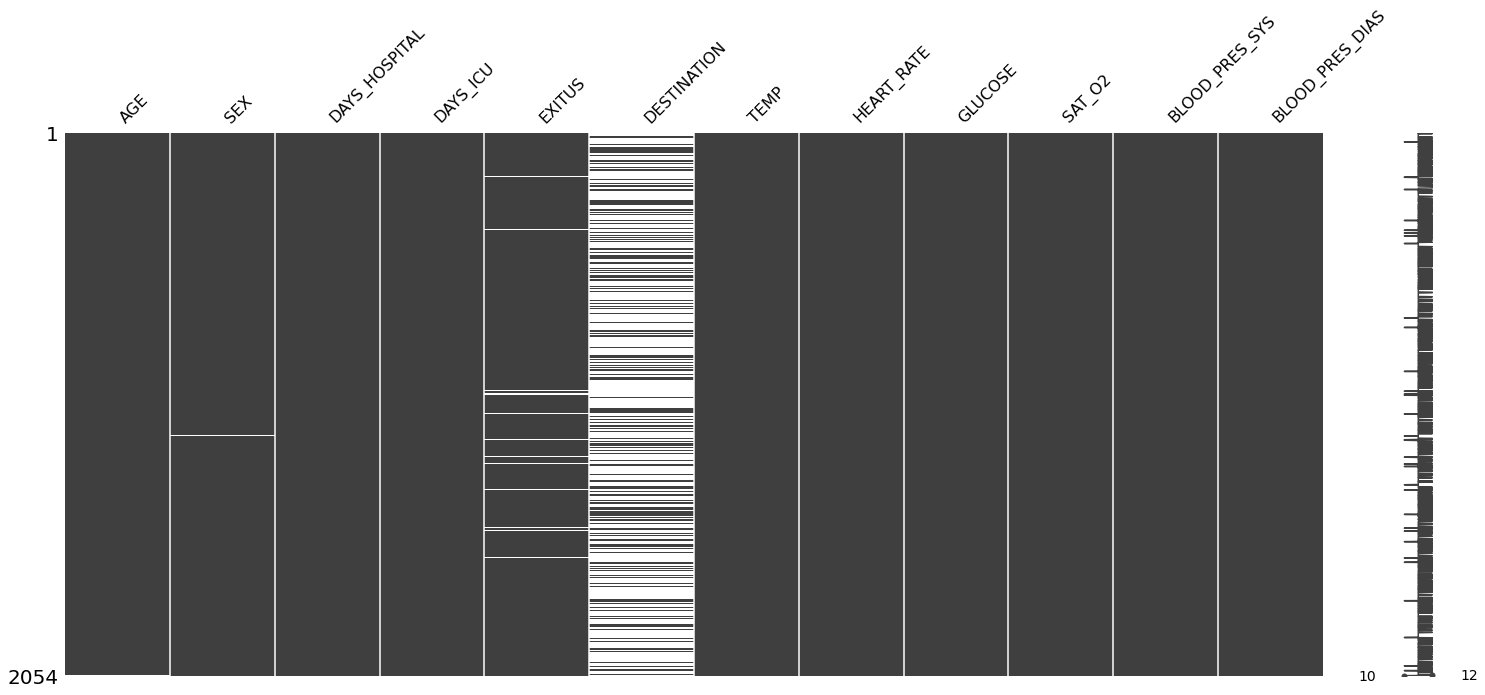

In [28]:
# Look at missing data
msno.matrix(df)
print("Missing values percentage:")
df.isnull().sum().sort_values(ascending=False)/len(df)*100

The above plot displays missing data per column in a row for all rows underneath eachother. White lines represent missing data.

### Observations
When looking at the data set, there are several questions which arise around column meanings and how realistic some values are.
Starting with giving a bit of context to some of the not so stright forward columns, brief explanations follow.

**Further column explanations**
* `DAYS_HOSPITAL`: The value 0 means that the patient went to the hospital, got their medical parameters taken, but was not admitted to the hospital, as they were deemed to not need medical attention.
* `DAYS_ICU`: If the health status of an admitted patient declined while at the hospital, they were admitted to the ICU.
* `EXITUS`: Indicates whether or not a patient died.
* `DESTINATION`: Indicates whether a patient coming to the hospital was admitted or goes home. As seen in df.info() earlier, there are only the states *ADMISSION* and missing values currently.

These further explanations reveal a *consistency problem* in the data set.
The `DESTINATION` variable is not only sparsly populated, it also does not match the `DAYS_HOSPITAL` column. For every entry in `DAYS_HOSPITAL` which is over 0, the `DESTINATION` would have to be *ADMISSION*. This is not the case.

---


As it is usually the case with real world data, this simulated data set also has missing and erroneous values. To know which values are realistic, a possible range, especially for the medical parameters is defined based on medical consensus covering all age groups and health levels. 

**Possible value ranges**
* `AGE`: [0 - 122] in years
* `TEMP`: [35 - 41] in Celcius
* `HEART_RATE`: [40 - 190] in bpm
* `GLUCOSE`: [35 - 380] in mg/dL
* `SAT_O2`: [30 - 100] mm Hg
* `BLOOD_PRES_SYS`: [30 - 200] in mm Hg
* `BLOOD_PRES_DIAS`: [25 - 130] in mm Hg 

With this information of the possible ranges, the data set can be judged on its "goodness" in terms of cleaness of the values. 
Across different variables we have incorrect, as in impossible, values that fall outside of the defined ranges. *These must be considered erroneous*.

All values that fall within the possible range for their respective columns will be considered correct going forward. While the general state of the data set can raise concerns about other possible issues due to, e.g. not conscientious filling out of data sheets during stressfull situations that occur during a pandemic at an overloaded hospital, the data set now must be trusted inside the realm of realisticness to be able to move forward. 

## Data Preparation
Based on the observations made, the data set now has to be prepared to be reasonably used.

There are different approaches that can be chosen when dealing with erronouse data.

First, the consistency problem in regards to `DAYS_HOSPITAL` and `DESTINATION` is tackled. 
The `DESTINATION` column is very sparsly populated. Because of this the assumption is made that in many cases the values in this not well maintained column will be incorrect.
Based on the understanding that if a patient has spent at least one day at the hospital they clearly were admitted to the hospital, the `DESTINATION` column is properly refilled.

In [29]:
# Sanity check that there are no entries where a patient was not admitted to the hospital, but still died. This would not make sense for us to know. 
check_df = df.loc[(df['DESTINATION'].str.contains('ADMISSION')==False) & (df['EXITUS'].str.contains('YES')),:]
print(f"There are {check_df.shape[0]} entries of patients not being admitted to the hospital, but still dying.")

There are 0 entries of patients not being admitted to the hospital, but still dying.


In [30]:
df['DESTINATION'] = np.where(df['DAYS_HOSPITAL'] >= 1, 'ADMISSION', 'NOT-ADMISSION')

Second, all impossible values will be replaced with *NANs* (missing values) as to not accidentily use them and also understand how much of the data is actually erroneous.

The defined possible range is used to cut off obviously erroneous data and then it is checked how much data is missing per variable.

In [31]:
df.AGE = df.apply(lambda x: x.AGE if ((x.AGE >= 0) and (x.AGE <= 120)) else np.nan, axis=1)
df.TEMP = df.apply(lambda x: x.TEMP if ((x.TEMP >= 35) and (x.TEMP <= 41)) else np.nan, axis=1)
df.HEART_RATE = df.apply(lambda x: x.HEART_RATE if ((x.HEART_RATE >= 40) and (x.HEART_RATE <= 190)) else np.nan, axis=1)
df.GLUCOSE = df.apply(lambda x: x.GLUCOSE if ((x.GLUCOSE >= 35) and (x.GLUCOSE <= 380)) else np.nan, axis=1)
df.SAT_O2 = df.apply(lambda x: x.SAT_O2 if ((x.SAT_O2 >= 30) and (x.SAT_O2 <= 100)) else np.nan, axis=1)
df.BLOOD_PRES_SYS = df.apply(lambda x: x.BLOOD_PRES_SYS if ((x.BLOOD_PRES_SYS >= 30) and (x.BLOOD_PRES_SYS <= 200)) else np.nan, axis=1) 
df.BLOOD_PRES_DIAS = df.apply(lambda x: x.BLOOD_PRES_DIAS if ((x.BLOOD_PRES_DIAS >= 25) and (x.BLOOD_PRES_DIAS <= 130)) else np.nan, axis=1)

Replacing all erroneous with missing values consequentially means that there now are more missing values.

Missing values percentage:


GLUCOSE            99.123661
BLOOD_PRES_SYS     36.854917
BLOOD_PRES_DIAS    36.660175
TEMP               22.979552
HEART_RATE         21.908471
SAT_O2             20.593963
EXITUS              1.996105
AGE                 0.243427
SEX                 0.097371
DESTINATION         0.000000
DAYS_ICU            0.000000
DAYS_HOSPITAL       0.000000
dtype: float64

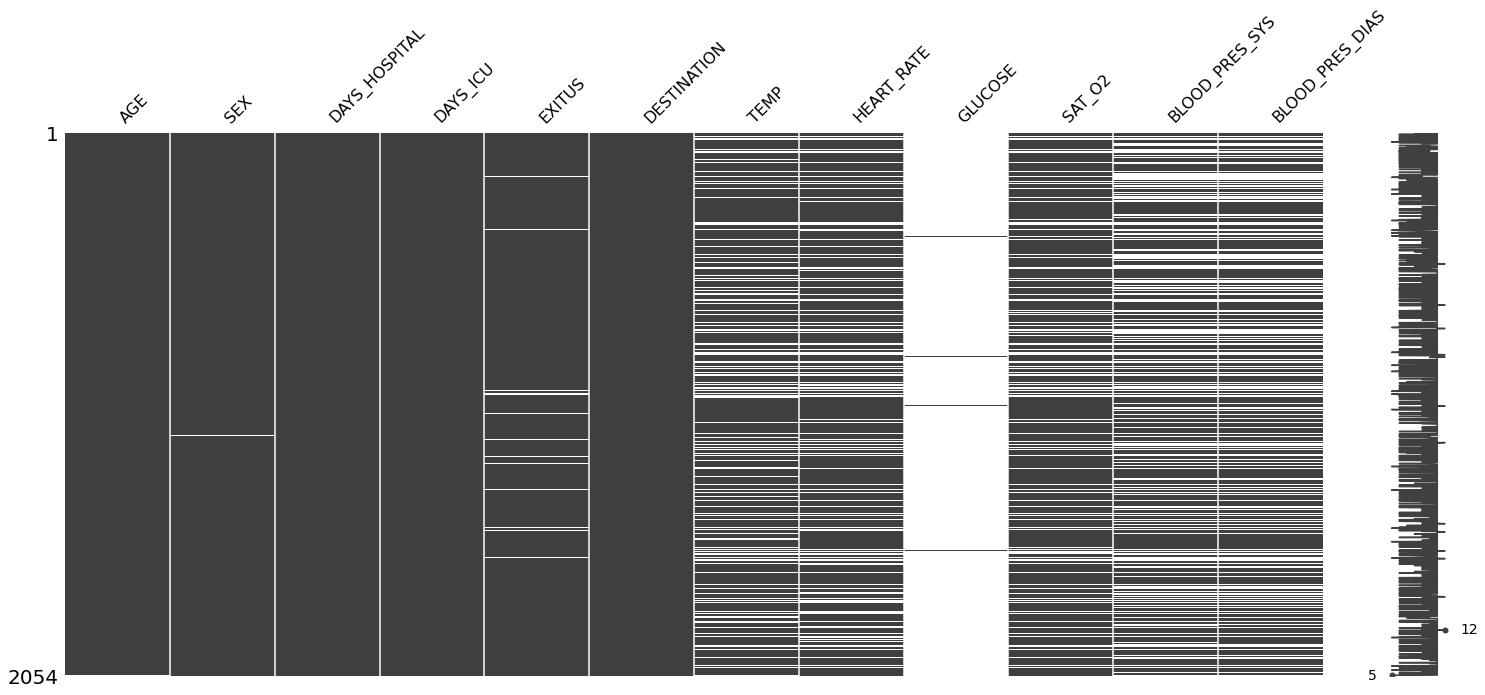

In [32]:
msno.matrix(df)
print("Missing values percentage:")
df.isnull().sum().sort_values(ascending=False)/len(df)*100

Now the options are to either dicard all rows or even entire columns, if there is too much missing data.
Or, to replace these values with, e.g average values or other imputation techniques.

### Working with drastically reduced data set size

Missing data in a data set must be eliminated. There are several ways to achieve this goal. Either data can be deleted or they can be imputed. This means that the missing values are replaced by synthetically generated values. Simple imputations include, for example, mean imputation or media imputation. However, other forms can also be applied. The synthetic generation of values, however, only makes sense with comparatively few missing data.

Since the proportion of missing data is particularly high for GLUCOSE (99%), BLOOD_PRES_SYS (37%), and BLOOD_PRES_DIAS (37%), imputation of data is not reasonable. 




In [33]:
#Select colums with high percentage of missing values 
columns_dropped = df.drop(['GLUCOSE', 'BLOOD_PRES_SYS', 'BLOOD_PRES_DIAS'], axis=1)
columns_dropped_non_null_data = columns_dropped[~columns_dropped.isnull().any(axis=1)]

print(f"The reduced data set has {columns_dropped_non_null_data .shape[0]} rows and {columns_dropped_non_null_data.shape[1]} columns.")
print("Missing values percentage:", columns_dropped_non_null_data.isnull().sum().sort_values(ascending=False)/len(columns_dropped_non_null_data)*100)


The reduced data set has 1496 rows and 9 columns.
Missing values percentage: SAT_O2           0.0
HEART_RATE       0.0
TEMP             0.0
DESTINATION      0.0
EXITUS           0.0
DAYS_ICU         0.0
DAYS_HOSPITAL    0.0
SEX              0.0
AGE              0.0
dtype: float64


**Imputation**

Several imputation strategies are reviewed below. 


1.   **Imputation after dopping three variables with most missing Data**
The previously mentioned GLUCOSE (99%), BLOOD_PRES_SYS (37%), and BLOOD_PRES_DIAS (37%) were removed from the data set. For all other values, values were imputed.
This ensures that the data set does not lose its size. However, values with 20% missing data are still imputed. This can already lead to problems.
2.   **Imputation after deleting rows with missing values in the variables with the most missing data** <br/>
Imputation after deleting rows with missing values in the variables with the most missing data.The missing values in the columns GLUCOSE , BLOOD_PRES_SYS, and BLOOD_PRES_DIAS are deleted. Then the values are imputed into the reduced data set. Again, values with about 20% missing data are imputed.
3. **Imputation after deleting rows with missing values in the variables with the most missing data** <br/>
In this procedure, only values below 5% missing data are imputed. According to most sources, this is almost safe.

**Basic information on the imputation methods used:**

*SimpleImputer*: Here the most occurring value is taken for the categorical variables and this is used for the corresponding missing values in the column of a variable.

*IterativeImputer*: The iterative imputer estimates values based on similar nearby values. The documentation states: 
*A strategy for imputing missing values by modeling each feature with missing values as a function of other features in a round-robin fashion.* <br/>
https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html




In [34]:
#Get categorical and numerical values
#We cant impute the values that have over 40 % missing data, 20% missing data is also quite a problem 

#For dropped GLUCOSE, BLOOD_PRESS_SYS and BLOOD_PRES_DIAS.
cat_cols = [col for col in columns_dropped.columns if col not in columns_dropped.describe().columns]
num_cols = [col for col in columns_dropped.columns if col in columns_dropped.describe().columns]

#Get the dataframes with categorical and numerical values.
cat_df = columns_dropped[cat_cols]
num_df = columns_dropped[num_cols]

from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

#Initialize imputation
simple_imp = SimpleImputer(strategy="most_frequent")
iterative_imp = IterativeImputer(max_iter=10, random_state=0)

#Modus imputation for cat variables (missing values below 2%)
cat_df_imp = simple_imp.fit_transform(cat_df) 
#Iterative imputation for values 
num_df_imp = iterative_imp.fit_transform(num_df)

#Init Dataframes
cat_df = pd.DataFrame(cat_df_imp, columns=cat_df.columns)
num_df = pd.DataFrame(num_df_imp, columns=num_df.columns)

imputed_df_full = pd.concat([cat_df.reset_index(),num_df.reset_index()], axis=1).drop(["index"],axis=1)

########## Imputations for values under 40% ##########################

reduced_df = df.drop(["GLUCOSE"],axis=1).dropna(subset=['BLOOD_PRES_SYS', 'BLOOD_PRES_DIAS'])

cat_cols = [col for col in reduced_df.columns if col not in reduced_df.describe().columns]
num_cols = [col for col in reduced_df.columns if col in reduced_df.describe().columns]

#Get the dataframes with categorical and numerical values.
cat_df = reduced_df[cat_cols]
num_df = reduced_df[num_cols]

#Modus imputation for cat variables (missing values below 2%)
cat_df_imp = simple_imp.fit_transform(cat_df) 
#Iterative imputation for values 
num_df_imp = iterative_imp.fit_transform(num_df)

#Init Dataframes
cat_df = pd.DataFrame(cat_df_imp, columns=cat_df.columns)
num_df = pd.DataFrame(num_df_imp, columns=num_df.columns)

imputed_df_reduced = pd.concat([cat_df.reset_index(),num_df.reset_index()], axis=1).drop(["index"],axis=1)

########## Imputations for values under 5% ###########################

reduced_df = df.drop(["GLUCOSE"],axis=1).dropna(subset=['BLOOD_PRES_SYS', 'BLOOD_PRES_DIAS', 'TEMP', 'HEART_RATE', 'SAT_O2'])

cat_cols = [col for col in reduced_df.columns if col not in reduced_df.describe().columns]

#Get the dataframes with categorical and numerical values.
cat_df = reduced_df[cat_cols]
num_df = reduced_df[num_cols]

#Modus imputation for cat variables (missing values below 2%)
cat_df_imp = simple_imp.fit_transform(cat_df) 


#Init Dataframes
cat_df = pd.DataFrame(cat_df_imp, columns=cat_df.columns)

imputed_df_reduced_cat = pd.concat([cat_df.reset_index(),num_df.reset_index()], axis=1).drop(["index"],axis=1)


print("The length of the dataframes: \n1.)",len(imputed_df_full),"\n2.)",len(imputed_df_reduced),"\n3.)",len(imputed_df_reduced_cat))

The length of the dataframes: 
1.) 2054 
2.) 1294 
3.) 1184


**Delete entries with missing data**

Another approach is to delete all entries of the dataset that contain missing data points. This leads to a drastic reduction of the dataset, as already seen in imputations 1) and 2). 

In [35]:
drop_col = df.drop(['GLUCOSE'], axis=1)
drop_col = drop_col[~drop_col.isnull().any(axis=1)]
non_null_data = drop_col[~drop_col.isnull().any(axis=1)]
print(f"The data set without any missing values has {non_null_data .shape[0]} rows and {non_null_data.shape[1]} columns.")

The data set without any missing values has 1169 rows and 11 columns.


**Conclusion** <br/> 
As shown with imputation, many data points must be estimated. This can lead to many errors in the course. If only data below 5% are taken, the gain in entries is only 15. Therefore, the imputed data sets are omitted in the further process.

## Uni- and Bivariate Data Analysis

The now cleaned data set will be explored again to get a better understanding of the actual data that is being worked with.


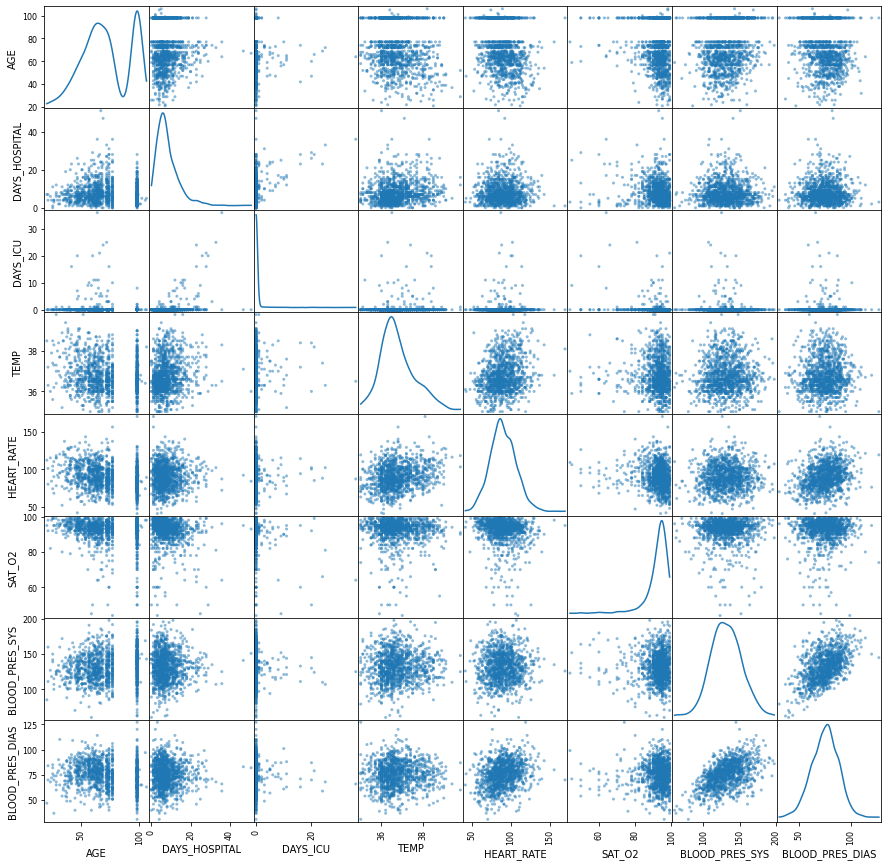

In [36]:
scat_matrix = pd.plotting.scatter_matrix(non_null_data, figsize=(15,15), diagonal="kde")

**Observations**

The scatter matrix above shows that most data is normally distributed, with the exceptions of DAYS_HOSPITAL and DAYS_ICU with a strong left skew and SAT_O2 with a right skew.
The first two left skewed variables are explained by the fact that a typical COVID-19 health progression only requires a few days at the hospital or ICU respectively. 


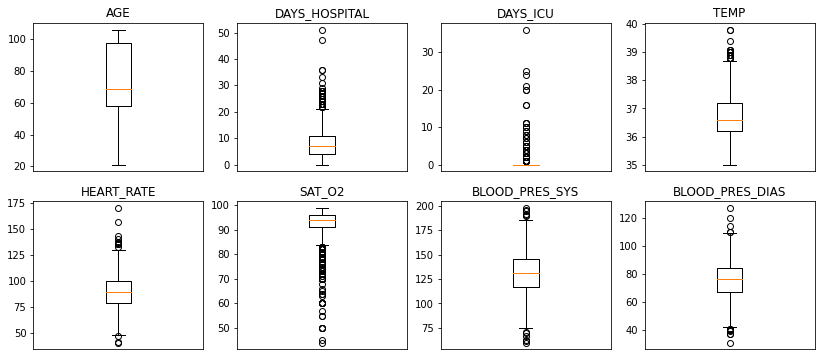

In [37]:
plt.figure(figsize=(14,6))
plt.subplots_adjust(hspace=0.2, wspace = 0.2)

plt_cols = ['AGE', 'DAYS_HOSPITAL', 'DAYS_ICU', 'TEMP', 'HEART_RATE', 'SAT_O2', 'BLOOD_PRES_SYS', 'BLOOD_PRES_DIAS']
for i in range(8):
  plt.subplot(2,4,(i+1))
  plt.boxplot(non_null_data[plt_cols[i]])
  plt.title(plt_cols[i])
  plt.xticks([], [plt_cols[i]])

plt.show()

The displayed boxplots graphically show the quantiles of each variable. The range of each variable is within the previously defined bounds, with some outliers visible. As the business goal is based on understanding which patients have a higher likelihood of dying, a next interesting step is to compare each variable against the target variable EXITUS to see if these outliers potentially are because of the EXITUS status. For this, boxplots and bar charts are used, as well as calculations on mean and standard deviation.

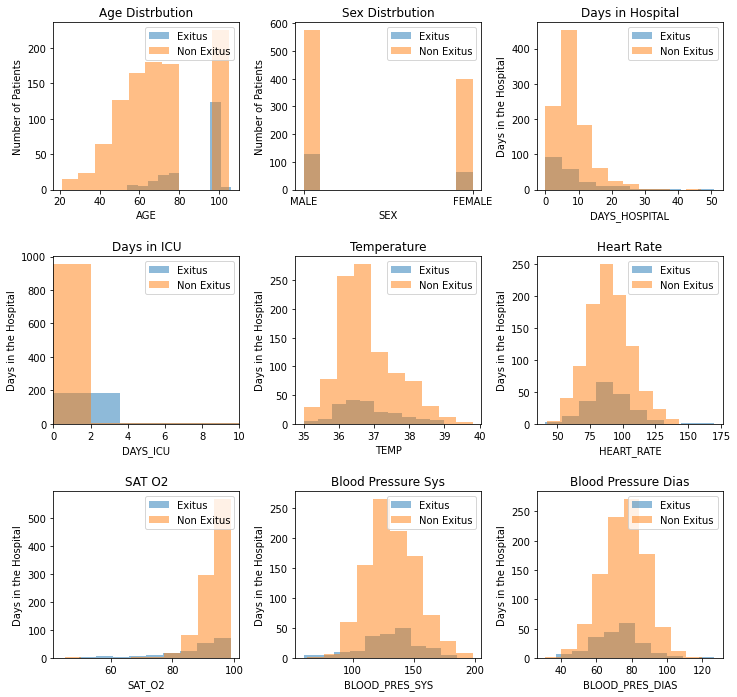

In [38]:
def seperateExitus(df, column):
  exitus = list(df.loc[df['EXITUS'] == 'YES'][column])
  non_exitus = list(df.loc[df['EXITUS'] == 'NO'][column])
  return (exitus, non_exitus)

plt.figure(figsize=(12,16))
plt.subplots_adjust(hspace=0.4, wspace = 0.3)

plt.subplot(4,3,1)
col = 'AGE'
exitus, non_exitus = seperateExitus(non_null_data, col)
plt.title('Age Distrbution')
plt.xlabel(col)
plt.ylabel('Number of Patients')
plt.hist(exitus, alpha=0.5, label='Exitus')
plt.hist(non_exitus, alpha=0.5, label='Non Exitus')
plt.legend(loc='upper right')

plt.subplot(4,3,2)
col = 'SEX'
exitus, non_exitus = seperateExitus(non_null_data, col)
plt.title('Sex Distrbution')
plt.xlabel(col)
plt.ylabel('Number of Patients')
plt.hist(exitus, alpha=0.5, label='Exitus')
plt.hist(non_exitus, alpha=0.5, label='Non Exitus')
plt.legend(loc='upper right')

plt.subplot(4,3,3)
col = 'DAYS_HOSPITAL'
exitus, non_exitus = seperateExitus(non_null_data, col)
plt.title('Days in Hospital')
plt.xlabel(col)
plt.ylabel('Days in the Hospital')
plt.hist(exitus, alpha=0.5, label='Exitus')
plt.hist(non_exitus, alpha=0.5, label='Non Exitus')
plt.legend(loc='upper right')

plt.subplot(4,3,4)
col = 'DAYS_ICU'
exitus, non_exitus = seperateExitus(non_null_data, col)
plt.title('Days in ICU')
plt.xlabel(col)
plt.xlim(0,10)
plt.ylabel('Days in the Hospital')
plt.hist(exitus, alpha=0.5, label='Exitus')
plt.hist(non_exitus, alpha=0.5, label='Non Exitus')
plt.legend(loc='upper right')


plt.subplot(4,3,5)
col = 'TEMP'
exitus, non_exitus = seperateExitus(non_null_data, col)
plt.title('Temperature')
plt.xlabel(col)
plt.ylabel('Days in the Hospital')
plt.hist(exitus, alpha=0.5, label='Exitus')
plt.hist(non_exitus, alpha=0.5, label='Non Exitus')
plt.legend(loc='upper right')

plt.subplot(4,3,6)
col = 'HEART_RATE'
exitus, non_exitus = seperateExitus(non_null_data, col)
plt.title('Heart Rate')
plt.xlabel(col)
plt.ylabel('Days in the Hospital')
plt.hist(exitus, alpha=0.5, label='Exitus')
plt.hist(non_exitus, alpha=0.5, label='Non Exitus')
plt.legend(loc='upper right')


plt.subplot(4,3,7)
col = 'SAT_O2'
exitus, non_exitus = seperateExitus(non_null_data, col)
plt.title('SAT O2')
plt.xlabel(col)
plt.ylabel('Days in the Hospital')
plt.hist(exitus, alpha=0.5, label='Exitus')
plt.hist(non_exitus, alpha=0.5, label='Non Exitus')
plt.legend(loc='upper right')


plt.subplot(4,3,8)
col = 'BLOOD_PRES_SYS'
exitus, non_exitus = seperateExitus(non_null_data, col)
plt.title('Blood Pressure Sys')
plt.xlabel(col)
plt.ylabel('Days in the Hospital')
plt.hist(exitus, alpha=0.5, label='Exitus')
plt.hist(non_exitus, alpha=0.5, label='Non Exitus')
plt.legend(loc='upper right')


plt.subplot(4,3,9)
col = 'BLOOD_PRES_DIAS'
exitus, non_exitus = seperateExitus(non_null_data, col)
plt.title('Blood Pressure Dias')
plt.xlabel(col)
plt.ylabel('Days in the Hospital')
plt.hist(exitus, alpha=0.5, label='Exitus')
plt.hist(non_exitus, alpha=0.5, label='Non Exitus')
plt.legend(loc='upper right')


plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

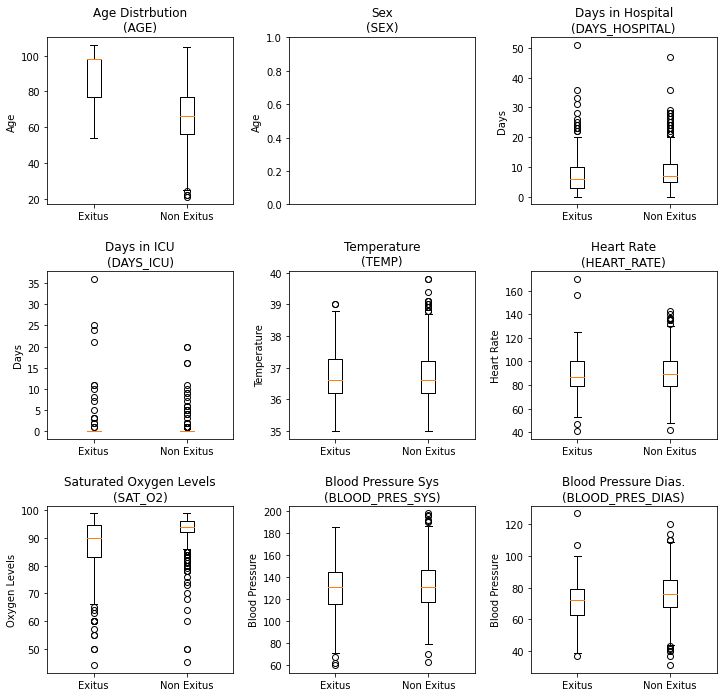

In [39]:
plt.figure(figsize=(12,16))
plt.subplots_adjust(hspace=0.4, wspace = 0.3)

plt.subplot(4,3,1)
col = 'AGE'
exitus, non_exitus = seperateExitus(non_null_data, col)
plot_data = {'exitus': exitus, 'non_exitus':non_exitus}
plt.title('Age Distrbution' + f'\n({col})')
plt.xticks([], ['Exitus', 'Non Exitus'])
plt.ylabel('Age')
plt.boxplot(plot_data.values())

plt.subplot(4,3,2)
col = 'SEX'
exitus, non_exitus = seperateExitus(non_null_data, col)
plot_data = {'exitus': exitus, 'non_exitus':non_exitus}
plt.title('Sex' + f'\n({col})')
plt.xticks([], ['Exitus', 'Non Exitus'])
plt.ylabel('Age')
# plt.boxplot(plot_data.values())

plt.subplot(4,3,3)
col = 'DAYS_HOSPITAL'
exitus, non_exitus = seperateExitus(non_null_data, col)
plot_data = {'exitus': exitus, 'non_exitus':non_exitus}
plt.title('Days in Hospital' + f'\n({col})')
plt.xticks([], ['Exitus', 'Non Exitus'])
plt.ylabel('Days')
plt.boxplot(plot_data.values())

plt.subplot(4,3,4)
col = 'DAYS_ICU'
exitus, non_exitus = seperateExitus(non_null_data, col)
plot_data = {'exitus': exitus, 'non_exitus':non_exitus}
plt.title('Days in ICU' + f'\n({col})')
plt.xticks([], ['Exitus', 'Non Exitus'])
plt.ylabel('Days')
plt.boxplot(plot_data.values())

plt.subplot(4,3,5)
col = 'TEMP'
exitus, non_exitus = seperateExitus(non_null_data, col)
plot_data = {'exitus': exitus, 'non_exitus':non_exitus}
plt.title('Temperature' + f'\n({col})')
plt.xticks([], ['Exitus', 'Non Exitus'])
plt.ylabel('Temperature')
plt.boxplot(plot_data.values())

plt.subplot(4,3,6)
col = 'HEART_RATE'
exitus, non_exitus = seperateExitus(non_null_data, col)
plot_data = {'exitus': exitus, 'non_exitus':non_exitus}
plt.title('Heart Rate' + f'\n({col})')
plt.xticks([], ['Exitus', 'Non Exitus'])
plt.ylabel('Heart Rate')
plt.boxplot(plot_data.values())

plt.subplot(4,3,7)
col = 'SAT_O2'
exitus, non_exitus = seperateExitus(non_null_data, col)
plot_data = {'exitus': exitus, 'non_exitus':non_exitus}
plt.title('Saturated Oxygen Levels' + f'\n({col})')
plt.xticks([], ['Exitus', 'Non Exitus'])
plt.ylabel('Oxygen Levels')
plt.boxplot(plot_data.values())

plt.subplot(4,3,8)
col = 'BLOOD_PRES_SYS'
exitus, non_exitus = seperateExitus(non_null_data, col)
plot_data = {'exitus': exitus, 'non_exitus':non_exitus}
plt.title('Blood Pressure Sys' + f'\n({col})')
plt.xticks([], ['Exitus', 'Non Exitus'])
plt.ylabel('Blood Pressure')
plt.boxplot(plot_data.values())

plt.subplot(4,3,9)
col = 'BLOOD_PRES_DIAS'
exitus, non_exitus = seperateExitus(non_null_data, col)
plot_data = {'exitus': exitus, 'non_exitus':non_exitus}
plt.title('Blood Pressure Dias.' + f'\n({col})')
plt.xticks([], ['Exitus', 'Non Exitus'])
plt.ylabel('Blood Pressure')
plt.boxplot(plot_data.values())

plt.show()

The boxplots help illustrate how the distribution of features differs between the exitus and non-exitus population. These boxplots show that patients that die (exitus population) tend to be older, have low saturated oxygen levels, and lower blood pressure relative to patients that survive. 


In [40]:
def printMeanAndSdByGroup(variables, groupvariable):
    data_groupby = variables.groupby(groupvariable)
    print("## Means:")
    display(data_groupby.apply(np.mean))
    print("\n## Standard deviations:")
    display(data_groupby.apply(np.std))
    print("\n## Sample sizes:")
    display(pd.DataFrame(data_groupby.apply(len)))
    
printMeanAndSdByGroup(non_null_data, non_null_data.EXITUS)

## Means:


,AGE,DAYS_HOSPITAL,DAYS_ICU,TEMP,HEART_RATE,SAT_O2,BLOOD_PRES_SYS,BLOOD_PRES_DIAS
EXITUS,,,,,,,,
NO,68.690256,8.060513,0.194872,36.772410,89.975385,93.227692,131.951795,75.819487
YES,88.561856,7.855670,0.891753,36.763918,89.396907,86.850515,130.237113,71.793814



## Standard deviations:


,AGE,DAYS_HOSPITAL,DAYS_ICU,TEMP,HEART_RATE,SAT_O2,BLOOD_PRES_SYS,BLOOD_PRES_DIAS
EXITUS,,,,,,,,
NO,19.300710,5.256442,1.433294,0.814514,16.223990,4.985873,20.422530,12.488281
YES,13.629062,7.434927,4.124810,0.833659,17.558215,11.162498,23.549147,13.402137



## Sample sizes:


,0
EXITUS,
NO,975
YES,194


**Observations**

It can be seen that people who survive are on average younger, spend fewer days at the ICU and have lower SAT_O2 levels.
However, it is important to note that there is a strong imbalance in the data set when it comes to the target variable.  


In [41]:
print('Target Variable Imbalance Ratio')
non_null_data.EXITUS.value_counts(normalize=True)

Target Variable Imbalance Ratio


NO     0.834046
YES    0.165954
Name: EXITUS, dtype: float64

Although it is very fortunate that most patients which contract COVID-19 survive, this poses a challenge for creating predication models. Imbalanced data sets can tend to have a bias issue towards overfitting on the dominant class. This must be taken into consideration when modeling algorithms and evaluating them.

## Multivariate Data Analysis 

The aim of multivariate analysis is to show relationships between variables. For this purpose, they are placed in a context to each other.

To make the data more comparable, categorical variables must be converted to numerical ones. Since the categorical variables present in the data set are variables with only two assumable values, they can be simply coded by 0 and 1. With the help of an correlation matrix, the correlation between two variables can be easily graphical represented. 

In [42]:
#Transforming categorical variables into numerical 
corr_df = non_null_data
corr_df["SEX"] = corr_df["SEX"].astype('category')
corr_df["SEX"] = corr_df["SEX"].cat.codes
corr_df["EXITUS"] = corr_df["EXITUS"].astype('category')
corr_df["EXITUS"] = corr_df["EXITUS"].cat.codes
corr_df["DESTINATION"] = df['DESTINATION'].fillna(0)
corr_df["DESTINATION"] = corr_df["DESTINATION"].astype('category')
corr_df["DESTINATION"] = corr_df["DESTINATION"].cat.codes
#corr = df.corr()
corr = corr_df.corr() # --> should be this, no?
corr.style.background_gradient(cmap='coolwarm')


,AGE,SEX,DAYS_HOSPITAL,DAYS_ICU,EXITUS,DESTINATION,TEMP,HEART_RATE,SAT_O2,BLOOD_PRES_SYS,BLOOD_PRES_DIAS
AGE,1.000000,-0.121754,0.002388,-0.057577,0.371429,-0.002612,-0.162827,-0.247708,-0.150117,0.163761,-0.156131
SEX,-0.121754,1.000000,0.074303,0.075257,0.057166,-0.011305,0.129343,0.023572,-0.082371,0.058078,0.132242
DAYS_HOSPITAL,0.002388,0.074303,1.000000,0.356931,-0.013425,-0.137809,0.154392,0.019065,-0.142951,-0.003466,-0.008435
DAYS_ICU,-0.057577,0.075257,0.356931,1.000000,0.120829,-0.014105,0.053202,0.016761,-0.231197,-0.036368,-0.022699
EXITUS,0.371429,0.057166,-0.013425,0.120829,1.000000,0.075603,-0.003864,-0.013080,-0.345924,-0.030402,-0.117625
DESTINATION,-0.002612,-0.011305,-0.137809,-0.014105,0.075603,1.000000,-0.018214,0.020638,-0.057957,-0.008166,-0.040823
TEMP,-0.162827,0.129343,0.154392,0.053202,-0.003864,-0.018214,1.000000,0.236836,-0.030102,0.045657,0.034328
HEART_RATE,-0.247708,0.023572,0.019065,0.016761,-0.013080,0.020638,0.236836,1.000000,-0.135691,0.036453,0.274832
SAT_O2,-0.150117,-0.082371,-0.142951,-0.231197,-0.345924,-0.057957,-0.030102,-0.135691,1.000000,-0.009564,0.023656
BLOOD_PRES_SYS,0.163761,0.058078,-0.003466,-0.036368,-0.030402,-0.008166,0.045657,0.036453,-0.009564,1.000000,0.521463


**Conclusion**

As shown in the correlation matrix, there are stronger relationships between some variables in the data set than between others. In addition to the comparatively high correlation between days in the hospital and days in the ICU, as well as BLOOD_PRES_SYS and BLOOD_PRES_DIAS, a correlation between the age of the patients and the increased probability of death is striking.



**PCA - Principal Component Analysis**

To get further insights into the data a reduction of the data by means of a PCA is possible. 

Compared to R the correlation circle is not part of sklearn. 
Therefore code was used from PCA Correlation Circle:
http://rasbt.github.io/mlxtend/user_guide/plotting/plot_pca_correlation_graph/

The article also states: 



*   Features with a positive correlation will be grouped together.
*   Totally uncorrelated features are orthogonal to each other.
*   Features with a negative correlation will be plotted on the opposing quadrants of this plot.


In [43]:
from sklearn.decomposition import PCA
corr_df = corr_df.dropna()
pca = PCA(n_components=3)
comp = pca.fit_transform(corr_df)

**Correlation Circle**



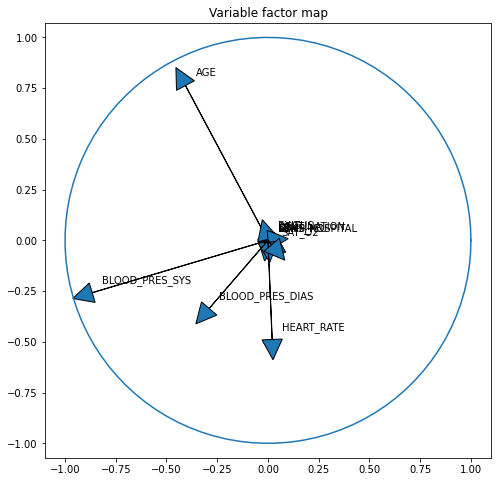

In [44]:
n_components = 2

# Plot a variable factor map for the first two dimensions.
(fig, ax) = plt.subplots(figsize=(8, 8))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[0, i],  #0 for PC1
             pca.components_[1, i],  #1 for PC2
             head_width=0.1,
             head_length=0.1)

    plt.text(pca.components_[0, i] + 0.05,
             pca.components_[1, i] + 0.05,
             corr_df.columns.values[i])


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
ax.set_title('Variable factor map')
plt.show()

The first two components account for about 67% of the variation in the data set. It can be seen that with increasing age, Blood_PES_SYS and BLOOD_PRESS_DIAS decrease correlatively.

Furthermore a scatterplot can be build, showing the data on the first 2 PC's. 

In [45]:
import plotly.express as px
from sklearn import datasets
from sklearn.preprocessing import StandardScaler


features = ["AGE","DAYS_HOSPITAL", "EXITUS", "BLOOD_PRES_SYS"]

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig = px.scatter(comp, x=0, y=1, color=corr_df['EXITUS'])

for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1]
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )
fig.show()

principalDf = pd.DataFrame(data = comp, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
print(pca.explained_variance_ratio_)
print(principalDf)

[0.38305676 0.32715135 0.16643888]
      principal component 1  principal component 2  principal component 3
0                 69.806524             -28.289776               3.643147
1                 39.499220             -26.236232             -27.799727
2                 -6.447173             -53.963643             -20.783581
3                 25.951286             -45.043066               0.698672
4                 31.830904             -28.520236             -25.174959
...                     ...                    ...                    ...
1164             -24.142558              28.893913              -9.367402
1165               9.835682              33.944290              12.722172
1166             -25.248421              24.903509               4.176419
1167             -52.307898              15.859309              -6.138102
1168             -20.034826              27.399750              12.090545

[1169 rows x 3 columns]


**Observations** <br/>
In the scatterplot the data points are divided into EXITUS = yellow and no EXITUS = blue. There is a tendency that the yellow points are distributed higher on the left side of the y-axis, while the blue points are located on the right side of the y-axis. With drawing in the variables it is to be recognized that the age points into the left upper corner. From this it can be concluded that there is a correlation between EXITUS and age.


## Survival Curves (Keplan-Meier)

<class 'pandas.core.frame.DataFrame'>


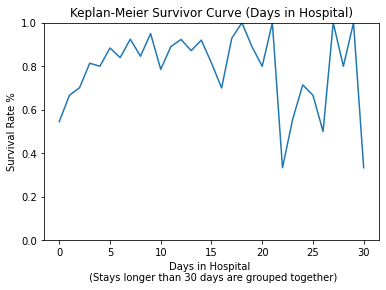

In [46]:
temp = non_null_data
temp['EXITUS_FLIPPED'] = temp.apply( lambda x: 1 if x['EXITUS'] == 0 else 0, axis = 1)

cut_off = 30
# Stays longer than the cut off are relabled to the cutoff because the data becomes sparse at the tales
# Therefore, all stays longer than 30 days are relabled as 30 days. 
# A nice step would be relabelign the final tick as 30+ rather than just 30
temp['DAYS_HOSPITAL_BUCKETED'] = temp.apply( lambda x: x['DAYS_HOSPITAL'] if x['DAYS_HOSPITAL'] <= cut_off else cut_off, axis = 1)
temp = temp.groupby(by = 'DAYS_HOSPITAL_BUCKETED')['EXITUS_FLIPPED'].mean().reset_index()


print(type(temp))
plt.title('Keplan-Meier Survivor Curve (Days in Hospital)')
plt.ylabel('Survival Rate %')
plt.xlabel(f'Days in Hospital \n (Stays longer than {cut_off} days are grouped together)')
plt.ylim(0,1)
plt.plot(temp['DAYS_HOSPITAL_BUCKETED'], temp['EXITUS_FLIPPED'])

**Observations**

A Keplan-Meier survival curve is used to plot the survival rate by the number of days a patient is in the hospital. All patients with a hospital stay of 30 days or greater are bucketed together at the 30 day ticker. The survival curve starts low at 56%, and trends upwards as a patient spends more days in the hospital. This means that most COVID deaths occur within the first few days a patient is admitted to the hospital. If a patient lives through the first five days of their hospital stay, they have an 80% chance of survival. 

<class 'pandas.core.frame.DataFrame'>


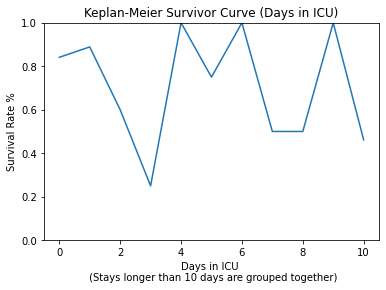

In [47]:
temp = non_null_data
temp['EXITUS_FLIPPED'] = temp.apply( lambda x: 1 if x['EXITUS'] == 0 else 0, axis = 1)

cut_off = 10
# Stays longer than the cut off are relabled to the cutoff because the data becomes sparse at the tales
# Therefore, all stays longer than 30 days are relabled as 30 days. 
# A nice step would be relabelign the final tick as 30+ rather than just 30
temp['DAYS_ICU_BUCKETED'] = temp.apply( lambda x: x['DAYS_ICU'] if x['DAYS_ICU'] <= cut_off else cut_off, axis = 1)
temp = temp.groupby(by = 'DAYS_ICU_BUCKETED')['EXITUS_FLIPPED'].mean().reset_index()


print(type(temp))
plt.title('Keplan-Meier Survivor Curve (Days in ICU)')
plt.ylabel('Survival Rate %')
plt.xlabel(f'Days in ICU \n (Stays longer than {cut_off} days are grouped together)')
plt.ylim(0,1)
plt.plot(temp['DAYS_ICU_BUCKETED'], temp['EXITUS_FLIPPED'])

**Observations**

Another Keplan-Meier survival curve was constructed to study how survival rate is impacted by the number of days in the ICU. This curve appears to show a lot more variability in day to day survival rates for ICU patients. Survival rates are high for patients that have a short stay in the ICU, but then there is a drop off in survival rate at days 2 and 3, before recovering to an average survival rate of around 80%.  

## ML Model


In order for the ML model to process the data properly, the data must first be scaled. To do this, the min-max scaler subtracts the corresponding value minus the smallest value of the column, and then divides by the largest value of the column minus the smallest value of the column.

Thus, all values between 0 and 1 are scaled. 

In addition, a training data set and a test data set are formed from the scaled values.

In [48]:
from sklearn.model_selection import train_test_split, GridSearchCV, train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler


#Scaled data to normalize 
scaler = MinMaxScaler()
scaledData = pd.DataFrame(scaler.fit_transform(corr_df), columns=corr_df.columns)

#KFold for imba pipeline
kf = KFold(n_splits=5, shuffle=False)

from sklearn.model_selection import cross_val_score, train_test_split
#Simple train test split 
x_train, x_test, y_train, y_test = train_test_split(
    scaledData.loc[:, scaledData.columns.drop('EXITUS')], 
    scaledData.EXITUS,
    test_size=0.25,
    random_state=0)


#scoring parameters evaluated in cv-fold 5
from sklearn.model_selection import cross_validate
scoring = ['accuracy', 'precision', 'recall']


The target variable EXITUS is an unbalanced data set. This has the consequence that under circumstances wrong results arise with the ML processes. Therefore, data similar to the underrepresented data can be generated synthetically.

Example: <br/>If the actual result was 99 blue and 1 red, a prediction with 100 blue would have an accuracy of 99%.

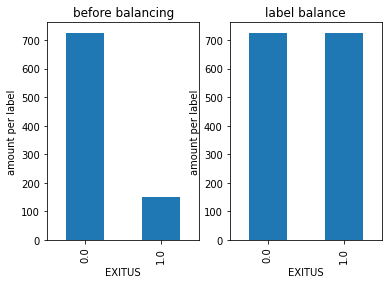

In [49]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE 
#Oversample testdata
x_train_upsample, y_train_upsample = SMOTE(random_state=42).fit_resample(x_train, y_train)

#Synthetic Minority Oversampling Techniqu
plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind='bar')
plt.title('before balancing')
plt.xlabel('EXITUS')
plt.ylabel('amount per label')

plt.subplot(1, 2, 2)
y_train_upsample.value_counts().plot(kind='bar')
plt.title('label balance')
plt.xlabel('EXITUS')
plt.ylabel('amount per label')
plt.show()



**Upsampling with SMOTE**

As shown in the figure, the data were synthetically complemented using SMOTE, so that EXITUS and non EXITUS are equally represented in terms of quantity. SMOTE - Synthetic Minority Oversample Technique generates data that are in a statistical sense, near to the data that is allready existing in the underrepresented class.

**Testclass**

In order to be able to further investigate the results in addition to well-known scores such as Accurracy, precision and Recall, the following test class was developed

Components are


*   a confusion matrix (Type I & Type II) Errors 
*   barplot (distribution of the predictions)

In the following, the models are initialized once with unbalanced data and non-optimized hyperparameters and once with balanced data and optimized hyperparameters.

**NOTE: The following evaluation is the same for all models**

In [50]:
from sklearn.metrics import plot_confusion_matrix

#define evaluation function
def evaluate_on_test_data(model,x_test,y_test):
  
  #predict values
  pred_values = model.predict(x_test)

  #scores and confusion matrix 
  score = model.score(x_test, y_test)
  rec_score = recall_score(y_test,pred_values)
  print('score:', score , 'recall_score:',rec_score)
  plot_confusion_matrix(model,x_test,y_test)  
  plt.show()

  print('y_test survived:',len(y_test[y_test==0]),'y_test exitus', len(y_test[y_test==1]))
  print('y_pred survived:',len(pred_values[pred_values==0]),'y_pred exitus',len(pred_values[pred_values==1]))

  cor_surv_pred = 0
  cor_exis_pred = 0
  act_exitus = 0
  act_surv = 0

  for y_pred,y  in zip(pred_values, y_test):
    #Surv Predicted and survived
    if y_pred== 0 and y== 0:
      cor_surv_pred = cor_surv_pred + 1
    #Exitus predicted and died
    elif y_pred== 1 and y == 1:
      cor_exis_pred = cor_exis_pred + 1
    #Exitus predicted and survived
    elif y_pred == 1 and y == 0:
      act_exitus = act_exitus + 1 
    #Survice Predicted and died
    elif y_pred == 0 and y == 1: 
      act_surv = act_surv + 1

  print(f"Pediciton: People died out of {len(y_test)}:",act_exitus / len(y_test))
  print(f"Actual values: People died out of {len(y_test)}:", len(y_test[y_test==1]) / len(y_test))

  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  langs = [ 'Corr Surv Pred','Corr Exitus Pred', 'False Exitus Pred', 'False Surv Pred']
  variables = [cor_surv_pred,cor_exis_pred,act_exitus,act_surv]
  ax.bar(langs,variables)
  plt.show()

Single Evalutation: 0.8839590443686007
__________________________________
On imbalanced dataset:
Test Accuracy: [0.85227273 0.85714286 0.84       0.84571429 0.86857143] 
Test Precision: [0.83333333 0.85714286 0.66666667 0.8        0.76923077] 
Test Recall: [0.16666667 0.2        0.13333333 0.13333333 0.33333333]
score: 0.8839590443686007 recall_score: 0.3181818181818182


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



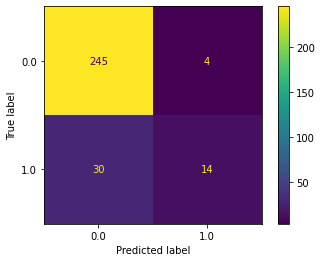

y_test survived: 249 y_test exitus 44
y_pred survived: 275 y_pred exitus 18
Pediciton: People died out of 293: 0.013651877133105802
Actual values: People died out of 293: 0.15017064846416384


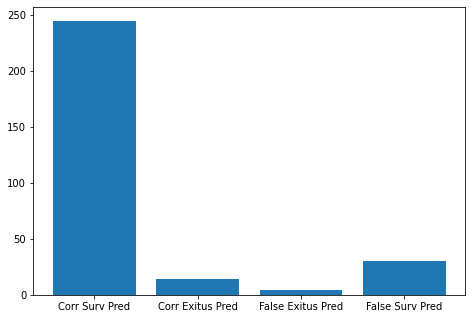

In [51]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

#Logistic Regression 
logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)
predictions = logisticRegr.predict(x_test)
log_reg_score = logisticRegr.score(x_test, y_test)
log_reg_scores = cross_validate(logisticRegr, x_train,y_train, cv=5, scoring=scoring)
print("Single Evalutation:",log_reg_score)
print("__________________________________\nOn imbalanced dataset:")
print(f'Test Accuracy: {log_reg_scores["test_accuracy"]} \nTest Precision: {log_reg_scores["test_precision"]} \nTest Recall: {log_reg_scores["test_recall"]}')
evaluate_on_test_data(logisticRegr, x_test, y_test)

**Pipeline with CV (Cross Validation) and Upsampling and GridSearch**



1.   **Pipeline:** <br/>
A pipeline allows multiple tasks to be processed in a predefined sequence. Here it is the upsampling of the data and the subsequent testing in the CV procedure
2.   **GridSearch** <br/>
GridSearch is used to test different hyperparameters. These vary depending on the model. The best parameters for the given scoring parameter (in our case F1 - balance between Precision and Recall)



In [52]:
from imblearn.pipeline import Pipeline, make_pipeline

imba_pipeline_logReg = make_pipeline(SMOTE(random_state=42), LogisticRegression(max_iter=400))
#cross_val_score(imba_pipeline_logReg, x_train,y_train, scoring='recall', cv=kf)
#cv_res = cross_validate(imba_pipeline_logReg, x_train,y_train, cv=kf, scoring=scoring)
#print(cv_res)
params = dict(logisticregression__C= [100, 10, 1.0, 0.1, 0.01], logisticregression__penalty=['l2'])

grid_imba = GridSearchCV(imba_pipeline_logReg, param_grid=params, cv=kf, scoring='f1',
                        return_train_score=True)

grid_imba.fit(x_train, y_train)
#Found best parameters
print(grid_imba.best_params_)



{'logisticregression__C': 100, 'logisticregression__penalty': 'l2'}


The model is then trained with the appropriate parameters and upsampled data.

In this case: <br/>
C - Strength of the penalty
l2 -minimize both the Loss term and the regularization term

score: 0.7337883959044369 recall_score: 0.7272727272727273


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



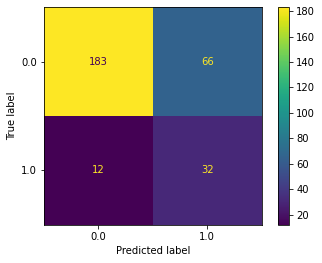

y_test survived: 249 y_test exitus 44
y_pred survived: 195 y_pred exitus 98
Pediciton: People died out of 293: 0.22525597269624573
Actual values: People died out of 293: 0.15017064846416384


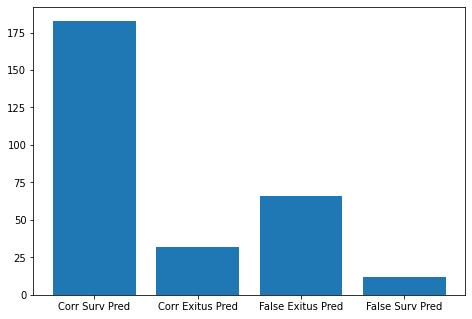

In [53]:
logReg_model = LogisticRegression(
    C=100,
    penalty='l2',
)
logReg_new_model = logReg_model.fit(x_train_upsample, y_train_upsample)

evaluate_on_test_data(logReg_new_model, x_test, y_test)

The model is then trained with the appropriate parameters and upsampled.

1.   C - Strength of the penalty
2.   l2 - minimize both the Loss term and the regularization term

**Note: The gridsearch is applied with diffrent parameters to every model**

Single Evalutation: 0.8839590443686007
__________________________________
On imbalanced dataset:
Test Accuracy: [0.84659091 0.84571429 0.85142857 0.82857143 0.86285714] 
Test Precision: [0.71428571 0.8        1.         0.5        0.875     ] 
Test Recall: [0.16666667 0.13333333 0.13333333 0.06666667 0.23333333]
score: 0.8839590443686007 recall_score: 0.25


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



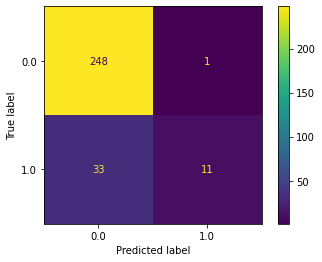

y_test survived: 249 y_test exitus 44
y_pred survived: 281 y_pred exitus 12
Pediciton: People died out of 293: 0.0034129692832764505
Actual values: People died out of 293: 0.15017064846416384


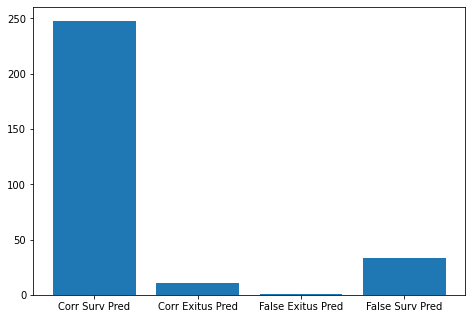

In [54]:
from sklearn import svm
#Support Vector Machines
clf = svm.SVC()
clf_model = clf.fit(x_train, y_train)
clf_score = clf.score(x_test,y_test)

clf_scores = cross_validate(clf, x_train, y_train, cv=5, scoring=scoring)
print("Single Evalutation:",clf_score)
print("__________________________________\nOn imbalanced dataset:")
print(f'Test Accuracy: {clf_scores["test_accuracy"]} \nTest Precision: {clf_scores["test_precision"]} \nTest Recall: {clf_scores["test_recall"]}')
evaluate_on_test_data(clf_model, x_test, y_test)


In [55]:
imba_pipeline_svm = make_pipeline(SMOTE(random_state=42),svm.SVC())
params = dict(svc__C= [100, 10, 1.0, 0.1, 0.01], 
              svc__kernel = ['poly', 'rbf', 'sigmoid'],
              svc__gamma = ['scale'])

grid_imba = GridSearchCV(imba_pipeline_svm, 
                         param_grid=params, 
                         cv=kf, 
                         scoring='f1',
                         return_train_score=True)

grid_imba.fit(x_train, y_train)
#Found best parameters
print(grid_imba.best_score_ , grid_imba.best_params_)

0.5218848492717651 {'svc__C': 1.0, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}


**Hyperparameters adjusted**


1.   C - strength of penalty
2.   Kernel - function used to transform input to output
3.   Gamma - defines how far influence of single training example reaches





score: 0.7508532423208191 recall_score: 0.7272727272727273


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



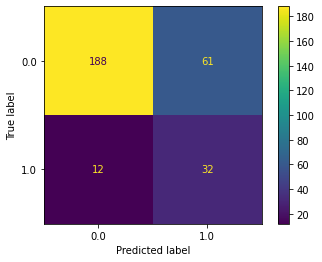

y_test survived: 249 y_test exitus 44
y_pred survived: 200 y_pred exitus 93
Pediciton: People died out of 293: 0.20819112627986347
Actual values: People died out of 293: 0.15017064846416384


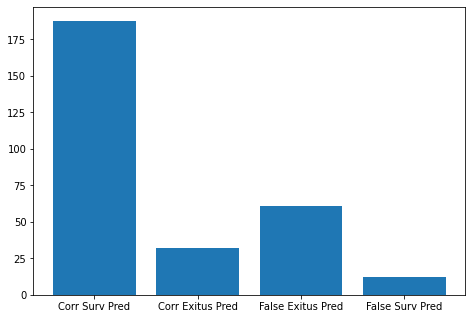

In [56]:
clf_new = svm.SVC(
    C=1.0,
    gamma='scale',
    kernel='rbf'
)

clf_new_model = clf_new.fit(x_train_upsample, y_train_upsample)

evaluate_on_test_data(clf_new_model, x_test, y_test)

Single Evalutation: 0.8771331058020477
Recall Score: 0.4318181818181818
__________________________________
On imbalanced dataset:
Test Accuracy: [0.88068182 0.82857143 0.82285714 0.84571429 0.88571429] 
Test Precision: [0.8        0.5        0.47058824 0.6        0.72727273] 
Test Recall: [0.4        0.26666667 0.26666667 0.3        0.53333333]
score: 0.8771331058020477 recall_score: 0.4318181818181818


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



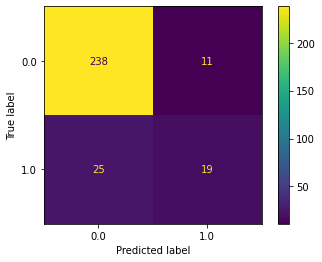

y_test survived: 249 y_test exitus 44
y_pred survived: 263 y_pred exitus 30
Pediciton: People died out of 293: 0.03754266211604096
Actual values: People died out of 293: 0.15017064846416384


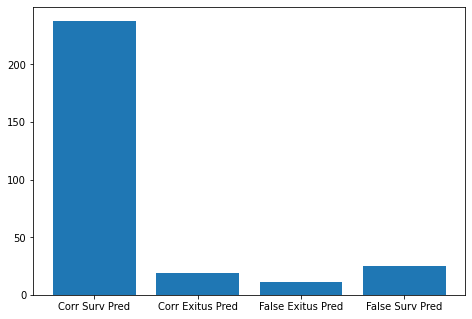

In [57]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
#Neural Netwroks
nnw = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1,max_iter=1000)
nnw_model = nnw.fit(x_train, y_train)
nnw_score = nnw.score(x_test, y_test)
#nnw_scores = cross_val_score(nnw, testX, testY, cv=10, scoring='recall')
nnw_scores = cross_validate(nnw, x_train, y_train, cv=5, scoring=scoring)

print("Single Evalutation:",nnw_score)
print("Recall Score:", recall_score(y_test,nnw.predict(x_test)))
print("__________________________________\nOn imbalanced dataset:")
print(f'Test Accuracy: {nnw_scores["test_accuracy"]} \nTest Precision: {nnw_scores["test_precision"]} \nTest Recall: {nnw_scores["test_recall"]}')

evaluate_on_test_data(nnw_model, x_test, y_test)


In [58]:
imba_pipeline_nnw = make_pipeline(SMOTE(random_state=42),
                                  MLPClassifier(random_state=1,max_iter=1000000))

parameter_space = {
    'mlpclassifier__hidden_layer_sizes': [(12,), (12,12), (100,)],
    'mlpclassifier__activation': ['tanh', 'relu'],
    'mlpclassifier__solver': ['sgd', 'adam'],
    'mlpclassifier__alpha': [0.0001, 0.05],
    'mlpclassifier__learning_rate': ['constant','adaptive'],
}

grid_imba = GridSearchCV(imba_pipeline_nnw, 
                         param_grid=parameter_space, 
                         cv=kf, 
                         scoring='f1',
                         return_train_score=True)

grid_imba.fit(x_train, y_train)
#Found best parameters
print(grid_imba.best_score_ , grid_imba.best_params_)

##13 Mins 
#Result 
#0.800370202134908 0.5544433254372402 {'mlpclassifier__activation': 'relu', 'mlpclassifier__alpha': 0.05, 'mlpclassifier__hidden_layer_sizes': (100,), 'mlpclassifier__learning_rate': 'constant', 'mlpclassifier__solver': 'adam'}


0.5544433254372402 {'mlpclassifier__activation': 'relu', 'mlpclassifier__alpha': 0.05, 'mlpclassifier__hidden_layer_sizes': (100,), 'mlpclassifier__learning_rate': 'constant', 'mlpclassifier__solver': 'adam'}


**Hyperparmameter**



1.   Hidden layer size - amount of hidden layers in nn
1.   Activation function - used activation function nn
2.   Solver - stocastic gradient descent
2.   alpha - leraning rate (portion of gradient)
2.   learning rate - constant or adaptive




score: 0.7440273037542662 recall_score: 0.7272727272727273


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



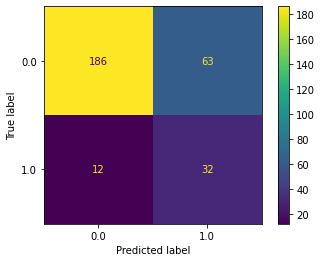

y_test survived: 249 y_test exitus 44
y_pred survived: 198 y_pred exitus 95
Pediciton: People died out of 293: 0.2150170648464164
Actual values: People died out of 293: 0.15017064846416384


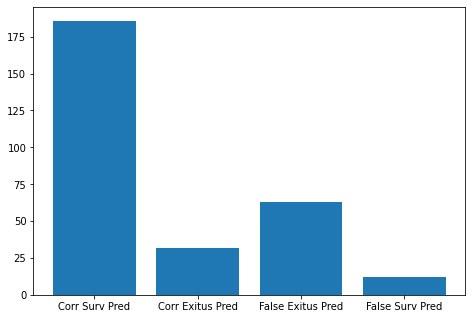

In [60]:
#This would lead to wrong results because upsampling was done before cross validation. 
#Therefore we build a pipeline, so upsampling is part of the crossvalidation
nnw_new = MLPClassifier(
    activation='relu',
    alpha=0.05, 
    hidden_layer_sizes=(100,), 
    learning_rate='constant', 
    random_state=1,
    max_iter=1000, 
    solver='adam')

nnw_new_model = nnw_new.fit(x_train_upsample, y_train_upsample)

evaluate_on_test_data(nnw_new_model, x_test, y_test)


**Conclusion after modelling**

*General:* <br/>
When comparing the models, it is noticeable that the accuracy, i.e. the correctly predicted values, is higher for the models for which no data were upsampled. This is due to the fact that a large proportion of cases are classified as non-exit. This increases the accuracy. In the cases where the data was upsampled, the model assumes an exitus in very many cases. This also increases the rate of correctly recognized EXITUS cases, but the rate of incorrectly recognized EXITUS cases even exceeds that of correctly recognized cases.

*According to our business goal:*

In the case of triage, the worst-case people are predicted to have no chance of survival even though they survive with medical assistance. Therefore, few correct EXITUS predictions are better than false ones. Hence, no model with upsampled data is selected. 

The comparison of the models shows that SVM predicted only one person incorrectly and 11 correctly. Survival was predicted in 33 people who died. However, this is more tolerable than incorrect EXITUS predictions.

Finally, it can be said that the data so far are not yet sufficient to create a properly predictive model. However, with increasing data during the course of the project, the models can be readjusted. However, the SVM had an accuracy of 11 out of 12 right predictions for the EXITUS
